#### Issues
1. Need more data to increase the size of the network and decrease bias and varience of trained model
2. case where dataset begins with bad calibration, not handled correctly. At the moment the first calibration is always flagged as a good calibration. 

#### TODO
* calculate VC dimension and calculations
* enforce tile count metric **complete**
* check polar coordinates **complete**
* try features importance ranking
* try cross validation training **complete**
* calculate high level errors **complete**
* pass predicted rotations **complete**
* examine input layer weights
* switch to keras

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
df = pd.read_csv('./matched16.csv')
df.head()

,dataset_name,frame_num,x,y,angle,d_0,d_1,d_2,d_3,d_4,...,l_num,r_num,x_residual,y_resdual,roll,pitch,yaw,roll_error,pitch_error,yaw_error
0,BathRoomLinearConst,0,454.990540,140.093643,-110.179947,51,223,254,126,55,...,617,596,4.275535e-09,0.147247,-1.640194,1.745557,-0.344377,-0.013379,0.073665,-0.049463
1,BathRoomLinearConst,0,178.902390,143.627304,-99.254578,251,31,239,219,119,...,617,596,3.215781e-09,-0.319340,-1.640194,1.745557,-0.344377,-0.013379,0.073665,-0.049463
2,BathRoomLinearConst,0,365.533051,147.686752,0.000000,127,63,255,126,55,...,617,596,4.714764e-09,0.179093,-1.640194,1.745557,-0.344377,-0.013379,0.073665,-0.049463
3,BathRoomLinearConst,0,302.299561,156.668839,0.000000,1,15,230,216,17,...,617,596,1.237111e-09,0.794478,-1.640194,1.745557,-0.344377,-0.013379,0.073665,-0.049463
4,BathRoomLinearConst,0,497.892426,171.168365,0.000000,115,95,206,94,55,...,617,596,4.236995e-09,-0.088111,-1.640194,1.745557,-0.344377,-0.013379,0.073665,-0.049463


### Introduction
The data provided here is per key-point match which are matched within the dyncal algorithm, the attributes for each key-point are:
* x pixel location
* y pixel location
* freak angle
* descriptor
* sigma
* octave
* laplacian score
* edge score
* minima

As well as the associated attributes of the matching, dyncal back-end, and gt errors:
* the descriptor distance (hamming distance)
* number of key-points in left and right image
* per match residual error from the back-end, for x and y displacement 
* final accumulated residual error after re-calibration, i.e. y + x displacement error 
* roll, pitch, and yaw axis errors

All these samples are tagged with the dataset name and frame number

### Goal
The aim of this notebook is to detail the design of a model which has learned the mapping from the key-point and matching attributes to the calibration quality achieved from Dyncal. The calibration quality can be either a binary decision good/bad (classification) or a continuous measure of quality (regression).

### Feature Selection
The following feature are calculated on a per frame basis from the dataset provided:
1. number of key-point matches
2. descriptor distance mean
3. descriptor distance standard deviation
4. disparity mean
5. disparity standard deviation
6. x coordinate mean
7. x coordinate standard deviation
8. y coordinate mean
9. y coordinate standard deviation
10. Non-linear optimisation final cost
11. number of key-points in left image
12. number of key-points in right image
13. number of outliers in Non-linear optimisation wrt. x residual
14. number of outliers in Non-linear optimisation wrt. y residual
15. . 31. matched key-point count per grid tile from left and right image in a 4x4 gird.


####  Functions & Classes

In [3]:
class Dataset:
    def __init__(self, df):

        self.collate_data(df)
        
    def collate_data(self, df):
        self.dataset_roll = []
        self.dataset_pitch = []
        self.dataset_yaw = []
        self.dataset_gt_roll = []
        self.dataset_gt_pitch = []
        self.dataset_gt_yaw = []
        self.predictors = []
        self.taregts = []
        self.ds_index = []
        self.dataset_predictors = []
        self.dataset_targets = []
        self.gt_roll = []
        self.gt_pitch = []
        self.gt_yaw = []
        
        for dataset_name in df.dataset_name.unique():

            self.ds_index.append(dataset_name)
            dataset_data = df.loc[df.dataset_name == dataset_name]
            seq_predictors = []
            seq_targets = []
            seq_roll = []
            seq_pitch = []
            seq_yaw = []
            seq_gt_roll = []
            seq_gt_pitch = []
            seq_gt_yaw = []

            for frame_num in dataset_data.frame_num.unique():
                
                # frame dataframe
                frame_data = dataset_data.loc[dataset_data.frame_num == frame_num]   
                frame_predictors = self.calculate_frame_predictors(frame_data)
                frame_targets = self.calculate_frame_targets(frame_data)
                
                # predicted rotations
                seq_roll.append(frame_data.roll.mean())
                seq_pitch.append(frame_data.pitch.mean())
                seq_yaw.append(frame_data.yaw.mean())
                
                # ground truth
                seq_gt_roll.append(frame_data.roll.values[0] - frame_data.roll_error.values[0])
                seq_gt_pitch.append(frame_data.pitch.values[0] - frame_data.pitch_error.values[0])
                seq_gt_yaw.append(frame_data.yaw.values[0] - frame_data.yaw_error.values[0])
                
                # frame attributes
                self.predictors.append(frame_predictors)
                seq_predictors.append(frame_predictors)
                
                # frame labels
                self.taregts.append(frame_targets)
                seq_targets.append(frame_targets)
            
            self.gt_roll.extend(seq_gt_roll)
            self.gt_pitch.extend(seq_gt_pitch)
            self.gt_yaw.extend(seq_gt_yaw)
            
            self.dataset_gt_roll.append(seq_gt_roll)
            self.dataset_gt_pitch.append(seq_gt_pitch)
            self.dataset_gt_yaw.append(seq_gt_yaw)

            self.dataset_roll.append(seq_roll)
            self.dataset_pitch.append(seq_pitch)
            self.dataset_yaw.append(seq_yaw)
            
            self.dataset_predictors.append(np.vstack(seq_predictors))
            self.dataset_targets.append(np.vstack(seq_targets))

        self.taregts = np.vstack(self.taregts)
        self.predictors = np.vstack(self.predictors)

    def calc_image_grid_count(self, x_data, y_data):
        num_bins_y = 4
        num_bins_x = 4
        bins = np.zeros((num_bins_y, num_bins_x))
        bin_x_size = 640/num_bins_x
        bin_y_size = 480/num_bins_y
        
        for x, y in zip(x_data, y_data):
            bins[int(y/bin_y_size), int(x/bin_x_size)] +=1
        
        return bins
    
    def calculate_frame_predictors(self, frame_data):
        
        self.attribute_names = ["match count", "desc dist mean", "desc dist std", "disp mean", "disp std", 
                                "x mean", "x std", "y mean", "y std", "cost", 
                                "match ratio left", "match ratio left", 
                                "y axis outliers", "x axis outliers"]
        for i in range(4*4):
            self.attribute_names.extend([f"grid {i}"])
        
        x_kps = np.concatenate((frame_data["x"].values, frame_data["x.1"].values), axis=None)
        y_kps = np.concatenate((frame_data["y"].values, frame_data["y.1"].values), axis=None)
        
        grid_coverage = self.calc_image_grid_count(x_kps, y_kps).flatten()
        
        self.attribute_names
        frame_attributes = []
        frame_attributes.append(frame_data.shape[0])
        frame_attributes.append(np.array(frame_data.desc_distance).mean())
        frame_attributes.append(np.array(frame_data.desc_distance).std())
        frame_attributes.append(np.array(frame_data["x"] - frame_data["x.1"]).mean())
        frame_attributes.append(np.array(frame_data["x"] - frame_data["x.1"]).std())
        frame_attributes.append(np.array(x_kps).mean())
        frame_attributes.append(np.array(x_kps).std())
        frame_attributes.append(np.array(y_kps).mean())
        frame_attributes.append(np.array(y_kps).std())
        frame_attributes.append(frame_data.final_cost.values[0])
        frame_attributes.append(frame_data.l_num.values[0])
        frame_attributes.append(frame_data.r_num.values[0])
        frame_attributes.append(sum([1 if abs(elem) > 0.25 else 0 for elem in frame_data.y_resdual.values]))
        frame_attributes.append(sum([1 if abs(elem) > 0.001 else 0 for elem in frame_data.x_residual.values]))
        frame_attributes.extend(grid_coverage)
        
        return np.array(frame_attributes)

    def calculate_frame_targets(self, frame_data):
        
        frame_labels = []
        frame_labels.append(abs(frame_data.yaw_error.mean()))
        frame_labels.append(abs(frame_data.pitch_error.mean()))
        frame_labels.append(abs(frame_data.roll_error.mean()))
        frame_labels.append(frame_labels[0] + frame_labels[1] + frame_labels[2])
        
        if frame_labels[-1] > 0.2:
            frame_labels.append(int(1))
        else:
            frame_labels.append(int(0))
        
        return np.array(frame_labels)
    
    def get_predictors(self):
        return self.predictors
    
    def get_target_labels(self):
        return self.taregts[:,4].T
    
    def get_errors(self):
        return self.taregts[:,3].T

    def get_yaw_gt(self):
        return np.array(self.gt_yaw).T
    
    def get_pitch_gt(self):
        return np.array(self.gt_pitch).T
       
    def get_roll_gt(self):
        return np.array(self.gt_roll).T
    
    def get_yaw_errors(self):
        return self.taregts[:,0].T
    
    def get_pitch_errors(self):
        return self.taregts[:,1].T
       
    def get_roll_errors(self):
        return self.taregts[:,2].T

    def get_num_datasets(self):
        return len(self.dataset_yaw)
    
    def get_dataframe(self):
        df = pd.DataFrame(self.get_predictors(), columns=self.get_attribute_names())
        df["target"] = self.get_target_labels()
        return df

    def get_num_samples(self):
        return self.taregts.shape[0]

    def get_dataset_names(self, i):
        return self.ds_index[i]
    
    def get_attribute_names(self):
        return self.attribute_names
    
    def get_dataset_roll(self, dataset_number):
        return self.dataset_roll[dataset_number]
    
    def get_dataset_pitch(self, dataset_number):
        return self.dataset_pitch[dataset_number]

    def get_dataset_yaw(self, dataset_number):
        return self.dataset_yaw[dataset_number]
    
    def get_gt_dataset_roll(self, dataset_number):
        return self.dataset_gt_roll[dataset_number]
    
    def get_gt_dataset_pitch(self, dataset_number):
        return self.dataset_gt_pitch[dataset_number]

    def get_gt_dataset_yaw(self, dataset_number):
        return self.dataset_gt_yaw[dataset_number]
    
    def get_dataset_predictors(self, dataset_number):
        return self.dataset_predictors[dataset_number]
    
    def get_dataset_target_labels(self, dataset_number):
        return self.dataset_targets[dataset_number][:,4]

    def get_dataset_target_errors(self, dataset_number):
        return self.dataset_targets[dataset_number][:,3]
    
    def convert_to_polar(self, x_data, y_data):
        rad = []
        teh = []
        for x, y in zip(x_data, y_data):
            x -= 320
            y -= 240
            rad.append(math.sqrt(x**2 + y**2))
            teh.append(math.atan(y/x))
        return rad, teh

In [4]:
def filter_data(window_size, data):
    filtered_data = []
    window_start = 0
    window_end = 0
    
    for elem in data:
        actual_window_size = window_end - window_start + 1
        acc_data = 0
        for window_elem in data[window_start : window_end + 1]:
            acc_data += window_elem

        window_average = acc_data/actual_window_size
        filtered_data.append(window_average)
        window_end += 1
        if window_end >= window_size:
            window_start += 1

    return filtered_data

def remove_bad_calibrations(data, masks):
    count = 0
    result = []
    last_good_cal = 0
    
    for element, mask in zip(data, masks):
        if mask and count != 0:
            result.append(data[last_good_cal])
        elif mask:
            last_good_cal = 0
            result.append(data[last_good_cal])
        else:
            last_good_cal = count
            result.append(element)
        
        count += 1

    return result

In [5]:
dataset = Dataset(df)

#### Display ground truth errors in dataset

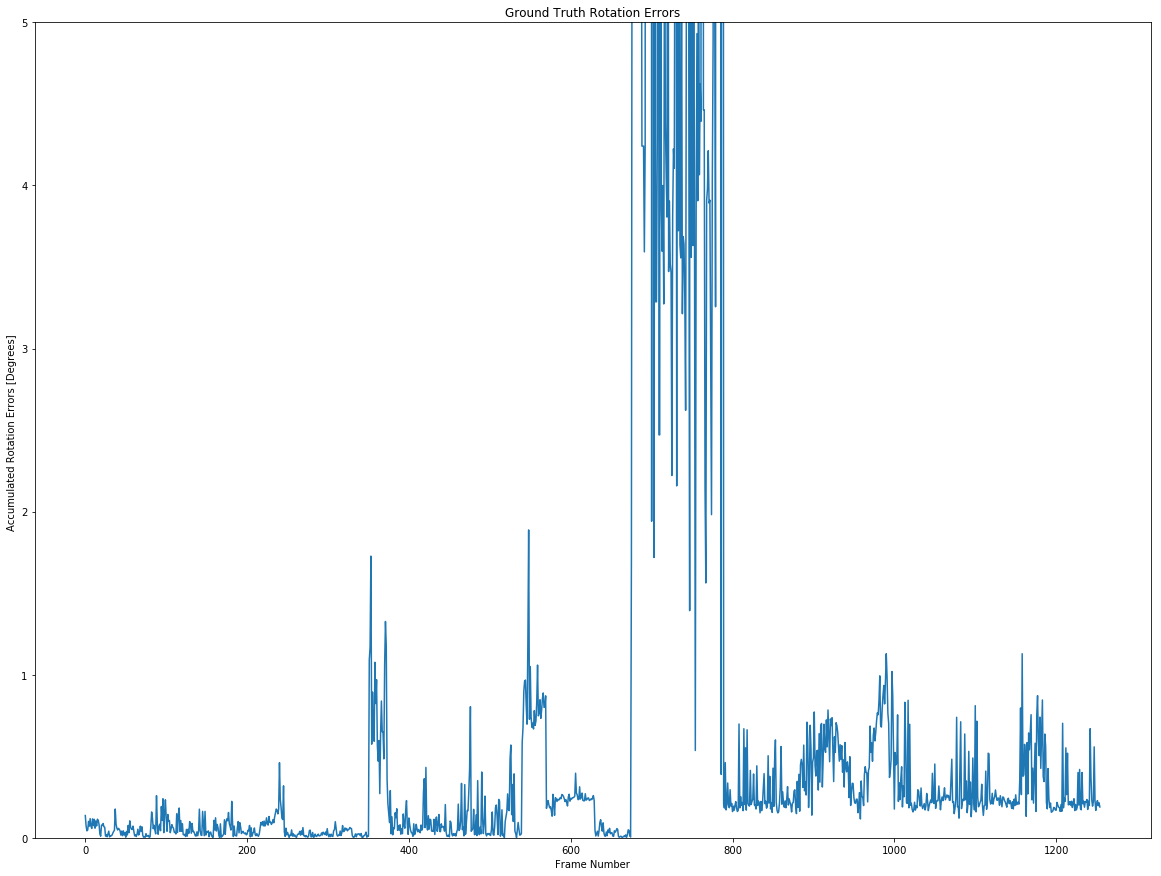

In [6]:
plt.figure(figsize=(20,15))
plt.plot(dataset.get_errors());
plt.xlabel("Frame Number")
plt.ylabel("Accumulated Rotation Errors [Degrees] ")
plt.title("Ground Truth Rotation Errors")
plt.ylim((0, 5));
plt.show()

#### Error stats per dataset

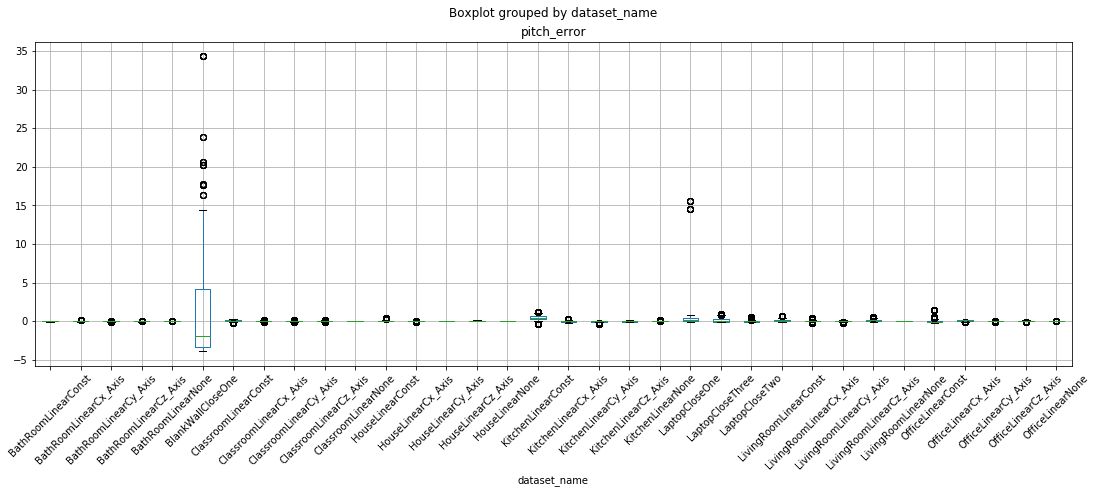

In [7]:
df.boxplot(column='pitch_error', by='dataset_name', rot=45, figsize=(18, 6))
plt.show()

In [8]:
dataframe = dataset.get_dataframe()
print(f"Distribution of values in target labels (0: good calibration, 1: bad calibration)\n\nLabel  Count\n{dataframe['target'].value_counts()}")

Distribution of values in target labels (0: good calibration, 1: bad calibration)

Label  Count
0.0    651
1.0    604
Name: target, dtype: int64


#### Training & Testing

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn import linear_model

X = dataset.get_predictors()
y = dataset.get_target_labels()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True, random_state=42)

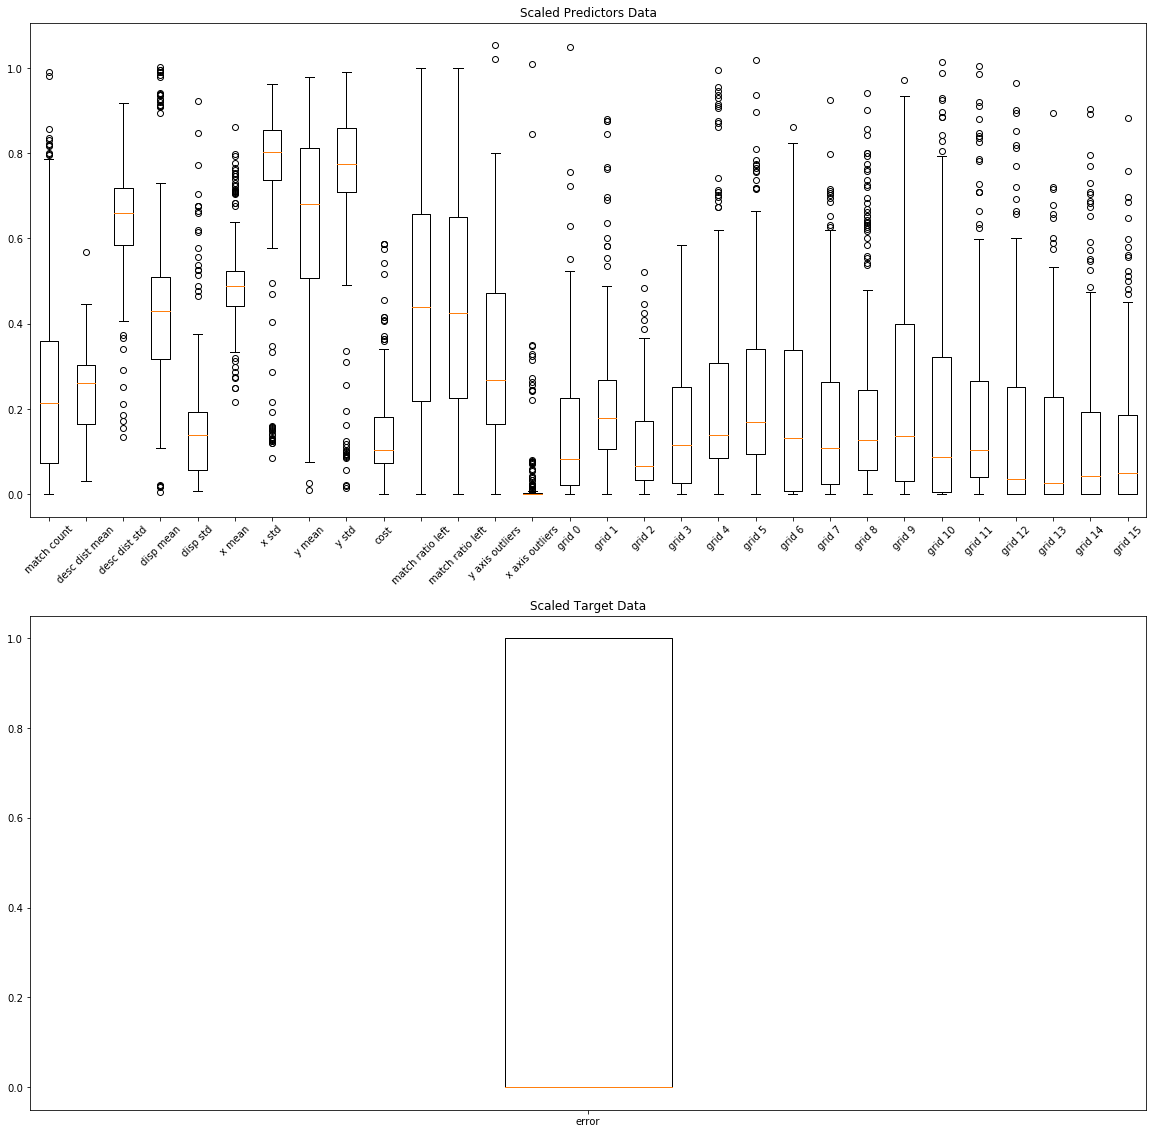

In [10]:
X_scaler = MinMaxScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

fig, ax = plt.subplots(2, 1, sharey='row', figsize=(20, 20))
ax[0].set_title('Scaled Predictors Data')
ax[0].boxplot(X_test, labels=dataset.get_attribute_names())

ax[1].set_title('Scaled Target Data')
ax[1].boxplot(y_test, labels=["error"])

plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_val_score

parameters = {'activation' : ['tanh', 'relu'],
              'solver' : ['lbfgs'], 
              'alpha' : [1e-2, 5e-2, 1e-1, 5e-1, 1], 
              'hidden_layer_sizes' : [(15), (32)]
}

clf = MLPClassifier(random_state=1)
clf = GridSearchCV(clf, parameters, cv=5)

clf.fit(X_train, y_train)

print(clf.best_params_)

{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 15, 'solver': 'lbfgs'}


In [20]:
# best estimator from grid search
clf = clf.best_estimator_

scores = cross_val_score(clf, X_train, y_train, cv=5)

y_pred = clf.predict(X_test)

print(f"Accuracy:\t\t{scores.mean():.2f} (+/- {(scores.std() * 2):.2f})") 
print(f"Train set score:\t{clf.score(X_train, y_train):.2f}")
print(f"Train set loss:\t\t{clf.loss_:.2f}")
print(f"Test set score:\t\t{clf.score(X_test, y_test):.2f}")
print(f"Recall (Test):\t\t{recall_score(y_test, y_pred):.2f}")
print(f"Percision (Test):\t{precision_score(y_test, y_pred):.2f}")

Accuracy:		0.86 (+/- 0.04)
Train set score:	0.89
Train set loss:		0.26
Test set score:		0.85
Recall (Test):		0.86
Percision (Test):	0.83


#### Model in Keras 

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
import keras.backend as K

# Defining a function which creates an arbitrary neural network
def create_model(indim):
    
    model = Sequential()

    # Add layer
    model.add(Dense(indim, input_dim=indim, kernel_initializer='normal', activation='tanh'))
    
    # Add layer with activation
    model.add(Dense(12, kernel_initializer='normal', activation='tanh'))
    
    # Add layer with activation
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    # Specify adam optimizer
#     opt = keras.optimizers.adam(lr=0.001, decay=1e-6)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])

    return model

# Create an instance of our model
model = create_model(X_train.shape[1])

# Print the model's summary
print(model.summary()) 


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Use tf.cast instead.


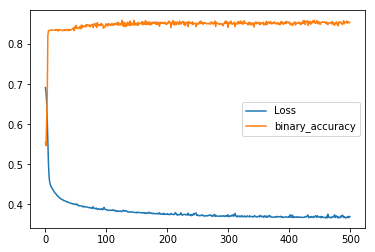

Final Training Accuracy:  0.8535856568955805
251/251 [==============================] - 0s 305us/step
Test [Loss, Accuracy] =  [0.4532696248525642, 0.7768924300414157]


In [14]:
# Define a function which plots training accuracy and loss across
# the different epochs.
def plot_loss_acc(history):
    # Plot loss
    plt.plot(history.history["loss"],label="Loss")
    # Plot Accuracy
    plt.plot(history.history["binary_accuracy"],label="binary_accuracy")
    plt.legend()
    plt.show()

# Train the model
model_history = model.fit(X_train, y_train, verbose=0, epochs=500, batch_size=64)
    
# Make Acc and Loss versus Epochs plot 
plot_loss_acc(model_history)

print("Final Training Accuracy: ", model_history.history["binary_accuracy"][499])

# Evaluate model (loss, accuracy)
print("Test [Loss, Accuracy] = ", model.evaluate(X_test, y_test))


Here recall is the most important metric. Recall measures the ratio of the correctly classified bad calibration with the number of actual bad calibrations, i.e.  (# true positives/ # false negatives +  # true positives). Since we care more about capturing all bad calibrations rather than reporting false alarms, false positves. It is reasonable to allow false alarms since the average filter will provide stability in these cases.

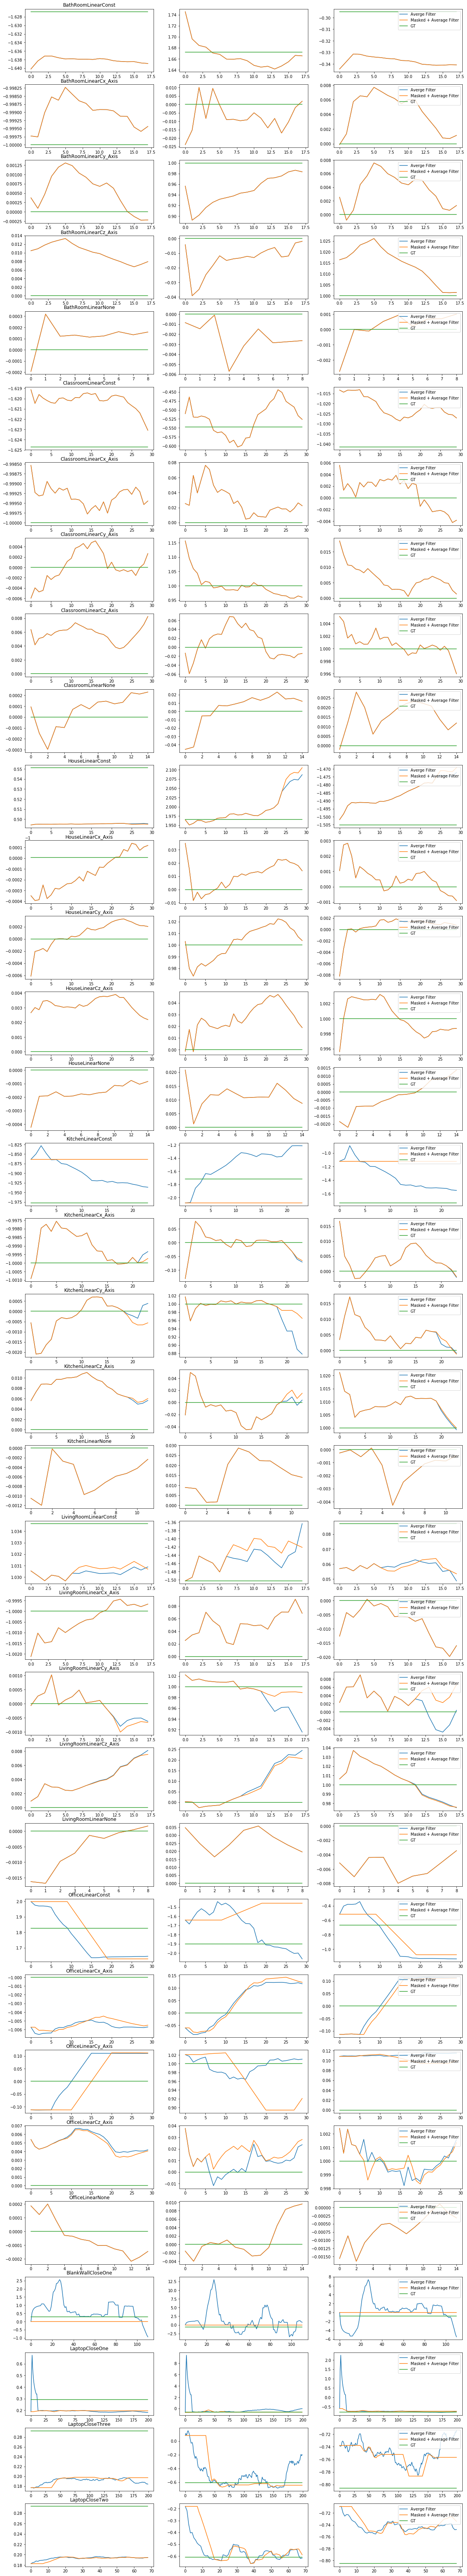

In [15]:
fig, ax = plt.subplots(dataset.get_num_datasets(), 3, figsize=(20, 120))
all_filtered_roll_data = []
all_filtered_pitch_data = []
all_filtered_yaw_data = []
all_masked_filtered_roll_data = []
all_masked_filtered_pitch_data = []
all_masked_filtered_yaw_data = []

for i in range(dataset.get_num_datasets()):
    
    datset_name = dataset.get_dataset_names(i)
    gt_masks = dataset.get_dataset_target_labels(i)
    errors = dataset.get_dataset_target_errors(i)

    # scale the data
    dataset_predictors = X_scaler.transform(dataset.get_dataset_predictors(i))
    masks = clf.predict(dataset_predictors)
    
    roll = dataset.get_dataset_roll(i)
    pitch = dataset.get_dataset_pitch(i)
    yaw = dataset.get_dataset_yaw(i)
    
    gt_roll = dataset.get_gt_dataset_roll(i)
    gt_pitch = dataset.get_gt_dataset_pitch(i)
    gt_yaw = dataset.get_gt_dataset_yaw(i)
    
    filtered_roll_data = filter_data(10, roll)
    filtered_pitch_data = filter_data(10, pitch)
    filtered_yaw_data = filter_data(10, yaw)
    
    filtered_mask_roll_data = filter_data(10, remove_bad_calibrations(roll, masks))
    filtered_mask_pitch_data = filter_data(10, remove_bad_calibrations(pitch, masks))
    filtered_mask_yaw_data = filter_data(10, remove_bad_calibrations(yaw, masks))
    
    all_filtered_roll_data.extend(filtered_roll_data)
    all_filtered_pitch_data.extend(filtered_pitch_data)
    all_filtered_yaw_data.extend(filtered_yaw_data)
    
    all_masked_filtered_roll_data.extend(filtered_mask_roll_data)
    all_masked_filtered_pitch_data.extend(filtered_mask_pitch_data)
    all_masked_filtered_yaw_data.extend(filtered_mask_yaw_data)
    
    #plt.plot(errors, label="Raw");
    ax[i, 0].plot(filtered_roll_data, label="Averge Filter")
    ax[i, 0].plot(filtered_mask_roll_data, label="Masked + Average Filter");
    ax[i, 0].plot(gt_roll, label="GT");
    ax[i, 0].set_title(datset_name)
        
    ax[i, 1].plot(filtered_pitch_data, label="Averge Filter");
    ax[i, 1].plot(filtered_mask_pitch_data, label="Masked + Average Filter");
    ax[i, 1].plot(gt_pitch, label="GT");
    
    ax[i, 2].plot(filtered_yaw_data, label="Averge Filter");
    ax[i, 2].plot(filtered_mask_yaw_data, label="Masked + Average Filter");
    ax[i, 2].plot(gt_yaw, label="GT");
    ax[i, 2].legend(loc='upper right')

plt.show()

In [16]:
# calc high level kpis
mf_r_err = np.array(all_masked_filtered_roll_data) - dataset.get_roll_gt()
mf_p_err = np.array(all_masked_filtered_pitch_data) - dataset.get_pitch_gt()
mf_y_err = np.array(all_masked_filtered_yaw_data) - dataset.get_yaw_gt()
f_r_err = np.array(all_filtered_roll_data) - dataset.get_roll_gt()
f_p_err = np.array(all_filtered_pitch_data) - dataset.get_pitch_gt()
f_y_err = np.array(all_filtered_yaw_data) - dataset.get_yaw_gt()

mf_r_m_err = np.absolute(mf_r_err).mean()
mf_p_m_err = np.absolute(mf_p_err).mean()
mf_y_m_err = np.absolute(mf_y_err).mean()
mf_r_std_err = mf_r_err.std()
mf_p_std_err = mf_p_err.std()
mf_y_std_err = mf_y_err.std()
f_r_m_err = np.absolute(f_r_err).mean()
f_p_m_err = np.absolute(f_p_err).mean()
f_y_m_err = np.absolute(f_y_err).mean()
f_r_std_err = f_r_err.std()
f_p_std_err = f_p_err.std()
f_y_std_err = f_y_err.std()

print(f"Roll Errors:\t\t\tMean\tSTD\n\tFiltered + Masked:\t{mf_r_m_err:.2f}\t{mf_r_std_err:.2f}\n\tFiltered:\t\t{f_r_m_err:.2f}\t{f_r_std_err:.2f}\n")
print(f"Pitch Errors:\t\t\tMean\tSTD\n\tFiltered + Masked:\t{mf_p_m_err:.2f}\t{mf_p_std_err:.2f}\n\tFiltered:\t\t{f_p_m_err:.2f}\t{f_p_std_err:.2f}\n")
print(f"Yaw Errors:\t\t\tMean\tSTD\n\tFiltered + Masked:\t{mf_y_m_err:.2f}\t{mf_y_std_err:.2f}\n\tFiltered:\t\t{f_y_m_err:.2f}\t{f_y_std_err:.2f}\n")


Roll Errors:			Mean	STD
	Filtered + Masked:	0.07	0.09
	Filtered:		0.09	0.23

Pitch Errors:			Mean	STD
	Filtered + Masked:	0.13	0.22
	Filtered:		0.35	1.21

Yaw Errors:			Mean	STD
	Filtered + Masked:	0.12	0.24
	Filtered:		0.26	0.86



Print out layer weights

In [17]:
for i, layer in enumerate(clf.coefs_):
    print(f"Layer {i}")
    for j, node in enumerate(layer):
        print(f"Node {j}: ")
        for node_weight in node:
            print(f"{node_weight:.3f}", end=" ")
        print("\n")
    

Layer 0
Node 0: 
-0.030 -0.993 -0.022 -0.214 0.576 -0.074 -0.282 0.197 -0.037 -0.212 0.317 0.037 -0.163 0.489 -0.352 

Node 1: 
0.061 2.281 -2.767 -0.080 1.866 0.281 -2.984 1.387 0.069 0.065 0.489 0.911 -0.201 -0.757 0.136 

Node 2: 
-0.144 1.529 -1.729 -0.154 1.065 0.466 -3.010 1.666 -0.173 -0.142 0.859 1.241 -0.197 -0.177 -0.355 

Node 3: 
-0.019 1.404 -3.057 0.132 -0.022 0.502 0.866 0.089 -0.084 -0.088 -0.335 0.557 -0.170 -0.827 0.204 

Node 4: 
-0.143 0.483 -2.243 -0.000 -2.785 -0.139 0.059 0.566 0.159 0.025 -0.065 0.535 -0.139 -0.542 -0.045 

Node 5: 
-0.120 1.688 -0.063 0.048 -0.735 0.899 -0.014 -1.089 -0.054 -0.275 0.023 -0.791 0.073 0.610 -0.056 

Node 6: 
-0.138 -0.828 0.674 -0.385 0.454 0.505 -0.525 0.811 -0.178 -0.233 0.644 0.369 -0.014 0.616 -0.285 

Node 7: 
0.044 -1.135 0.138 -0.123 -1.055 0.288 0.226 0.092 0.071 -0.447 0.365 -0.045 -0.005 0.517 -0.444 

Node 8: 
-0.172 -0.665 -1.708 -0.483 -0.036 0.679 -1.324 0.490 -0.135 -0.390 0.685 0.181 -0.135 0.677 -0.353 

Node 9: 